# Unpack Hub Clustering
#### Developed by Job de Vogel, Lisa-Marie Mueller and Jirri van den Bos

This project was developed for the course AR3B012 CORE, TU Delft. The goal of the 'Unpack' module is solving a Facility Location Problem, specifically finding the ideal number of hubs placed in a city, with their locations, considering all inhabitants of the city, based on user prefered weights.

The project has been tested on the Windows operating system. We do not guarantee this code working on other types of operating systems.

Altough thoroughly tested, we do not recommend using this project in commercial context. It has been developed for educational purposes only.

To be able to run this code efficiently, we recommend the following hardware:
- 16 GB or RAM;
- 6 core CPU (more is better);
- Good internet connection for data retrieval.

In [1]:
# Import the package developed by UNPACK
import unpack
import random

In [2]:
## Initialize variables
name = 'Delft_center_walk'
data_folder = 'data/'
vehicle_type = 'walk' # walk, bike, drive, all (See osmnx documentation)
coordinates = [52.018347, 52.005217, 4.369142, 4.350504]
#coordinates =  [52.03, 51.96, 4.4, 4.3] # Full Delft

## GENERATE NETWORK
Generate a new network using the functions in the CityNetwork class. If a network already has been generated and stored in the data folder, 
please continue with 'Prepare Network'!

In [3]:
# Initialize CityNetwork object [N, S, E, W]
City = unpack.CityNetwork(name, data_folder, coordinates, vehicle_type)

In [4]:
# Initialize data folder to save results
City.makedirs(data_folder)

In [5]:
# Load osm from local or online file
# If sever does not respond, please try again in 30 seconds
City.load_osm_graph(data_folder, name)
City.load_building_addr(data_folder, name)

print('Loading finished.')

Retrieving online data...
Saving...
Finished loading
Loading buildings...
Searching for adresses...
Addresses found:12287
OSM address data saved to data/runtime/Delft_center_walk_addresses.csv
Searching for buildings...
Buildings found:2714
OSM building data saved to data/runtime/Delft_center_walk_buildings.csv
Assigning addresses and amenities to buildings:
12287 / 12287
Building/Adress data saved to data/runtime/Delft_center_walk_building_addresses.csv
Finished adding EPSG:3857 coordinates
Assigning buildings to CBS buurt
Checking if a building is inside a buurt
2161 / 2161
Adding the CBS data to the dataframe
2161 / 2161
Loading finished.


In [6]:
# Add speeds, lengths and distances to graph
# Overwrite speed by using overwrite_bike=16
# Further types available: overwrite_walk and overwrite_epv
City.add_rel_attributes(overwrite_bike=16, overwrite_walk=5)

In [7]:
# Project graph to the correct coordinate system
City.project_graph()

In [8]:
# (Optional) assign an 'experience' weight to the graph
# Experience can be added based on street names
latitude = 52.005831
longitude = 4.371026

City.add_street_experience(['Oude Delft'], [10])

In [9]:
# Calculate dataframes of nodes and edges
City.convert_graph_edges_to_df()
City.convert_graph_nodes_to_df()

In [10]:
# Extract the destinations
destinations = City.get_yx_destinations()

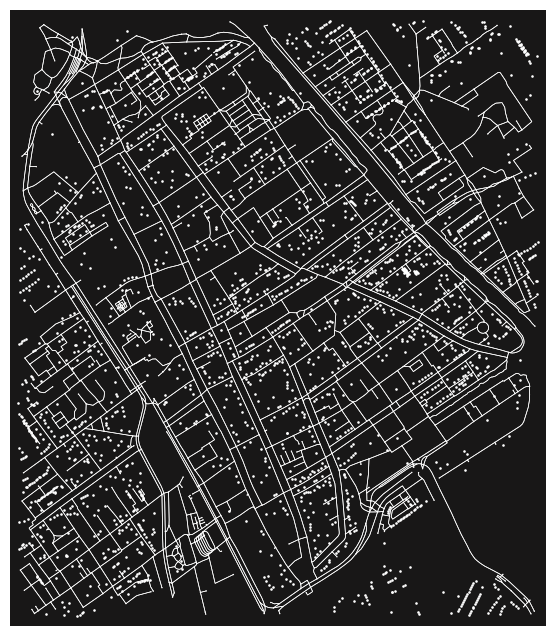

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [11]:
# (Optional) Plot the network
City.plot(destinations=destinations, show=True)

In [12]:
# (Optional) Save Pickle file of CityNetwork object
City.save_graph(name, data_folder)

Saving Delft_center_walk to data/runtime/Delft_center_walk.pkl


## Prepare Network
Load the CityNetwork object if it already has been initialized in a .pkl file.

In [3]:
# Load the CityNetwork
City = unpack.CityNetwork.load_graph(name, data_folder)

Loading...
Loaded Delft_center_walk to object...


## Compute Nearest Edges
To be able to compute shortest paths and clusters in the network, the nearest edges in the graph for each house have to be known. Therefore a multicore nearest edge algorithm has been developed.

Computing nearest edges may have a considerable computation time. Therefore it is recommended to run the computation once, and save the class object as a .pkl file again afterwards.

Approximate computation times:
* Full Delft: 15 minutes
* Delft city center: 30 seconds

In [14]:
# Compute nearest edges
# ! Run only once !
cpus = None # Indicate number of cores in your device, None for max available

City.ne = None
City.nearest_edges(5, cpus=cpus)
City.save_graph(name, data_folder)

Interpolating MultiDiGraph with 1257 nodes and 3468 edges for finding nearest edges...
Finished interpolating in 2.52s...
Finding 2161 nearest edges with 12 CPUs...
USER-WARNING: Make sure you put the multicore_nearest_edge function in a 'if __name__ == '__main__' statement!


100%|██████████| 2161/2161 [00:16<00:00, 128.36it/s]


Found 2161 edges in 19.32s with 12 CPUs...
Saving Delft_center_walk to data/runtime/Delft_center_walk.pkl


In [4]:
# Remove houses further than x meters from edges
City.drop_outliers(30)
dest_edges = City.ne

# Extract new yx destinations
destinations = City.get_yx_destinations()

Dropped 481 outliers further than 30m from edges


## Compute shortest paths
For this project, a multicore single source Dijkstra algorithm has been implemented to find the shortest paths between hubs and the closest houses. The code is adapted from OSMnx (Gboeing) and Taxicab (Nathan Rooy) but adds several functionalities. For more information, please check the code in multicore_shortest_path.

In [8]:
# Calculate shortest paths by hub
# Check the code for description of inputs.
# For smaller networks, single core can be 2x faster than multicore.
num_hubs = 3
random.seed(2)
hubs = [(random.randint(6801030, 6803490), random.randint(484261, 486397)) for _ in range(num_hubs)]
# hubs = [(6801181, 486566)] # Architecture faculty

# Note: the status bar in output viewer indicates when a set of origins
# is sent to the cpu, not when it is finished.
paths = unpack.multicore_single_source_shortest_path(City.graph, hubs, destinations, dest_edges,
    skip_non_shortest=True, 
    skip_treshold=60,
    weight='travel_time', 
    cutoff=None, 
    cpus=3
    )

USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
Solving 3 single sources using dijkstra algorithm with cutoff None on weight 'travel_time', skipping non-shortest paths with treshold 60 using 3 CPUs...


100%|██████████| 3/3 [00:00<00:00,  6.55it/s]


Skipped 40 paths with treshold 60 on weight travel_time.


In [9]:
# Convert results to DataFrame
colors = ['red', 'blue', 'green']
paths_df = unpack.paths_to_dataframe(paths, colors, hubs=hubs)
print(paths_df)

     Nearest_hub_name  idx  Path_not_found   hub_x    hub_y Euclid_nearesthub  \
0               hub 2    2           False  485523  6801722             hub_3   
1               hub 0    0           False  484636  6801261             hub_1   
2               hub 2    2           False  485523  6801722             hub_3   
3               hub 2    2           False  485523  6801722             hub_3   
4               hub 2    2           False  485523  6801722             hub_3   
...               ...  ...             ...     ...      ...               ...   
1675            hub 2    2           False  485523  6801722             hub_3   
1676            hub 1    1           False  485739  6801377             hub_2   
1677            hub 2    2           False  485523  6801722             hub_3   
1678            hub 2    2           False  485523  6801722             hub_3   
1679            hub 2    2           False  485523  6801722             hub_3   

      Euclid_hubdistance   

## Multiplot
Computing many plots with large networks can be computationally expensive. The multiplot package has been developed by Unpack to be able to plot and save many images using multiple cores.

Note: this functions is mostly memory bound. Make sure you are using a device with enough memory if you are using many cores.

In [10]:
# For this example, the result of the shortest path computation is repeated for each core.
cpus = 12
colors = ['red', 'blue', 'green']

# Give a name, to avoid overwriting your plots
session_name = f'Multiplot_example_cpus_{cpus}'

# Extract the data from the saved DataFrame
# This is just for a one time example, in the actual algorithm, these values are extracted internally.
cluster_iterations = [list(paths_df.loc[:, 'Path'])] * cpus
session_name_mask = [f'{session_name}_0test_{i}' for i in range(cpus)]
color_masks = [list(paths_df.loc[:, 'Color_mask'])] * cpus
origins = [hubs] * cpus

unpack.multiplot_save(City, cluster_iterations, origins, destinations, session_name_mask, color_masks, colors, session_name=session_name, dpi=300, cpus=cpus, show=False)
print(f"Images saved to {data_folder + session_name + '/plot_pngs/' + session_name}")

Saving 12 plots using 12 CPUs...
USER-WARNING: Make sure you put the multiplot function in a 'if __name__ == '__main__' statement!


100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Images saved to data/Multiplot_example_cpus_12/plot_pngs/Multiplot_example_cpus_12


## Clustering
Compute the clusters using Adaptive Weighted K-means clustering. Our implementation of k-means uses k++ for initialization, but is able to adapt k based on the following fitness values.

- Maximum weight: check if any hub has a weight (travel time) that is greater than the maximum (2.5 minutes walking).

OR:

- Long travel time: check how many people have a weight (travel time) that is greater than the maximum (2.5 minutes), determine if this is more than 10% of the total people served.

AND:

- Capacity: check if the number of people served is less than the maximum capacity of a hub.
- Unassigned: check if the number of people not assigned to a hub is more than 10% of the total people served.

In [5]:
# Specify a name for this clustering process
cluster_name = input('Please input a unique clustering name: ')

# Initiate the cluster class in an object
clusters = unpack.NetworkClustering(cluster_name)

# Reset the internal hub data if object contains data
clusters.reset_hub_df(City)

In [16]:
# (Optional) If clustering crashed, load the latest iteration
continue_clustering = False

if continue_clustering:
    # Specify the cluster_name
    path = input("Please insert the file name that you would like to load to continue clustering: ")
    
    # Continue clustering
    clusters.continue_clustering(path)
    print('Starting with iteration ', clusters.iteration)

In [6]:
# Clustering settings
# Number of starting hubs
start_pt_ct = 3

# The number of new hubs to add when the fitness is not reached
point_count = 1

# Maximum CPU cores, use None for max available 
max_cpu_count = None

# Shortest path settings
skip_non_shortest=True
skip_treshold=60
weight='travel_time'
cutoff=1000

# Max travel time for users to hub in seconds
max_travel_time = 150

# Randome init seed
random.seed(12345)

# Colors used for the plots
hub_colors = ['red', 'tomato', 'orangered', 'lightsalmon', 'indianred', 'firebrick', 'gold', 'darkorange', 'yellow', 'yellowgreen', 'greenyellow', 'darkolivegreen', 'lawngreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'seagreen', 'darkslategray', 'blue', 'deepskyblue', 'steelblue', 'dodgerblue', 'skyblue', 'cornflowerblue', 'royalblue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'darkviolet', 'mediumorchid', 'darkmagenta', 'mediumvioletred', 'deeppink', 'palevioletred', 'crimson']

# For more settings, please look at internal kwargs of clustering.optimize_locations

In [7]:
# Load boundary coordinates in right format for clustering
boundary_coordinates = City.format_boundary_coordinates()

In [8]:
# Give a name, to avoid overwriting your plots
session_name = cluster_name

In [20]:
# The following setup takes about ... minutes to compute on an Intel i7-9750H CPU

# Optimize the locations of the hubs using Adaptive Weighted K-means Clustering
clusters.optimize_locations(City, session_name, data_folder, boundary_coordinates, destinations, weight, cutoff, skip_non_shortest, skip_treshold, start_pt_ct, point_count, max_travel_time, max_cpu_count, hub_colors, 
    max_people_served=2190, 
    max_additional_clusters=7, 
    max_iterations=5)

# For more settings, please look at internal kwargs of clustering.optimize_locations

Running k iteration 3 step 0...
Saving Delft_Center_Clustering_iteration 001_initialize.pkl to data/Delft_Center_Clustering/Delft_Center_Clustering_iteration 001_initialize.pkl
Iteration state saved as .pkl file
No hub dictionary assigned yet, initializing hub dictionary

       index              x             y  avg_weight  max_weight  \
hub 0      0  485160.281499  6.801093e+06         0.0         0.0   
hub 1      1  485828.091445  6.802807e+06         0.0         0.0   
hub 2      2  486231.591204  6.801749e+06         0.0         0.0   

       people_served  
hub 0            0.0  
hub 1            0.0  
hub 2            0.0  

USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
USER-WARNING: Number of origins to compute is lower than number of cpu core

100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Skipped 426 paths with treshold 60 on weight travel_time.
------------------------------------

Running k iteration 3 optimization step 1...
USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
USER-WARNING: Number of origins to compute is lower than number of cpu cores used. It is recommended to set cpus=1 for better performance.
Solving 3 single sources using dijkstra algorithm with cutoff 1000 on weight 'travel_time', skipping non-shortest paths with treshold 60 using 12 CPUs...


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Skipped 294 paths with treshold 60 on weight travel_time.
Moved hubs on average 119.57 meters
Hub 0: avg. weight: 344.23, std. weight: 133.34, max weight 765.6, people served per hub: 6719
Hub 1: avg. weight: 413.23, std. weight: 166.79, max weight 772.42, people served per hub: 6597
Hub 2: avg. weight: 500.76, std. weight: 153.92, max weight 856.82, people served per hub: 1660

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 419.41, avg. std: 151.35, avg. people served: 4992

------------------------------------

Running k iteration 3 optimization step 2...
USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
USER-WARNING: Number of origins to compute is lower than 

100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Skipped 441 paths with treshold 60 on weight travel_time.
Moved hubs on average 32.96 meters
Hub 0: avg. weight: 371.11, std. weight: 118.86, max weight 1096.95, people served per hub: 6587
Hub 1: avg. weight: 455.56, std. weight: 169.54, max weight 811.29, people served per hub: 6401
Hub 2: avg. weight: 506.05, std. weight: 143.74, max weight 792.8, people served per hub: 1988

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 444.24, avg. std: 144.04, avg. people served: 4992

------------------------------------

Hub 0: avg. weight: 371.11, std. weight: 118.86, max weight 1096.95, people served per hub: 6587
Hub 1: avg. weight: 455.56, std. weight: 169.54, max weight 811.29, people served per hub: 6401
Hub 2: avg. weight: 506.05, std. weight: 143.74, max weight 792.8, people served per hub: 1988

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unas

100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Skipped 552 paths with treshold 60 on weight travel_time.
------------------------------------

Running k iteration 4 optimization step 1...
USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
USER-WARNING: Number of origins to compute is lower than number of cpu cores used. It is recommended to set cpus=1 for better performance.
Solving 4 single sources using dijkstra algorithm with cutoff 1000 on weight 'travel_time', skipping non-shortest paths with treshold 60 using 12 CPUs...


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Skipped 876 paths with treshold 60 on weight travel_time.
Moved hubs on average 246.41 meters
Hub 0: avg. weight: 362.2, std. weight: 105.5, max weight 1101.52, people served per hub: 6219
Hub 1: avg. weight: 392.25, std. weight: 138.36, max weight 790.79, people served per hub: 4587
Hub 2: avg. weight: 507.53, std. weight: 142.75, max weight 792.8, people served per hub: 2005
Hub 3: avg. weight: 287.05, std. weight: 147.88, max weight 597.02, people served per hub: 2164

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 387.26, avg. std: 133.62, avg. people served: 3744

------------------------------------

Running k iteration 4 optimization step 2...
USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing

100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Skipped 720 paths with treshold 60 on weight travel_time.
Moved hubs on average 85.53 meters
Hub 0: avg. weight: 374.81, std. weight: 123.09, max weight 927.96, people served per hub: 5940
Hub 1: avg. weight: 370.16, std. weight: 128.46, max weight 909.06, people served per hub: 5476
Hub 2: avg. weight: 517.11, std. weight: 148.26, max weight 846.59, people served per hub: 1778
Hub 3: avg. weight: 374.48, std. weight: 101.07, max weight 659.1, people served per hub: 1782

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 409.14, avg. std: 125.22, avg. people served: 3744

------------------------------------

Hub 0: avg. weight: 374.81, std. weight: 123.09, max weight 927.96, people served per hub: 5940
Hub 1: avg. weight: 370.16, std. weight: 128.46, max weight 909.06, people served per hub: 5476
Hub 2: avg. weight: 517.11, std. weight: 148.26, max weight 846.59, people served per hub: 1778
H

100%|██████████| 5/5 [00:01<00:00,  4.67it/s]


Skipped 1180 paths with treshold 60 on weight travel_time.
------------------------------------

Running k iteration 5 optimization step 1...
USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
USER-WARNING: Number of origins to compute is lower than number of cpu cores used. It is recommended to set cpus=1 for better performance.
Solving 5 single sources using dijkstra algorithm with cutoff 1000 on weight 'travel_time', skipping non-shortest paths with treshold 60 using 12 CPUs...


100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Skipped 1084 paths with treshold 60 on weight travel_time.
Moved hubs on average 74.48 meters
Hub 0: avg. weight: 506.27, std. weight: 118.13, max weight 795.79, people served per hub: 4884
Hub 1: avg. weight: 348.69, std. weight: 123.28, max weight 962.52, people served per hub: 5661
Hub 2: avg. weight: 587.15, std. weight: 204.51, max weight 1023.88, people served per hub: 1946
Hub 3: avg. weight: 175.86, std. weight: 72.77, max weight 409.15, people served per hub: 1092
Hub 4: avg. weight: 331.59, std. weight: 104.49, max weight 593.73, people served per hub: 1393

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 389.91, avg. std: 124.63, avg. people served: 2995

------------------------------------

Hub 0: avg. weight: 506.27, std. weight: 118.13, max weight 795.79, people served per hub: 4884
Hub 1: avg. weight: 348.69, std. weight: 123.28, max weight 962.52, people served per hub: 5661

100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Skipped 1882 paths with treshold 60 on weight travel_time.
------------------------------------

Running k iteration 6 optimization step 1...
USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
USER-WARNING: Number of origins to compute is lower than number of cpu cores used. It is recommended to set cpus=1 for better performance.
Solving 6 single sources using dijkstra algorithm with cutoff 1000 on weight 'travel_time', skipping non-shortest paths with treshold 60 using 12 CPUs...


100%|██████████| 6/6 [00:01<00:00,  4.53it/s]


Skipped 2114 paths with treshold 60 on weight travel_time.
Moved hubs on average 280.23 meters
Hub 0: avg. weight: 331.09, std. weight: 101.26, max weight 648.14, people served per hub: 3652
Hub 1: avg. weight: 271.92, std. weight: 104.74, max weight 545.4, people served per hub: 3486
Hub 2: avg. weight: 472.31, std. weight: 107.05, max weight 630.21, people served per hub: 1132
Hub 3: avg. weight: 272.59, std. weight: 124.25, max weight 603.98, people served per hub: 1382
Hub 4: avg. weight: 314.76, std. weight: 159.65, max weight 1020.08, people served per hub: 4010
Hub 5: avg. weight: 266.2, std. weight: 136.15, max weight 604.94, people served per hub: 1316

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 321.48, avg. std: 122.19, avg. people served: 2496

------------------------------------

Running k iteration 6 optimization step 2...
USER-WARNING: Make sure you put the multicore_sing

100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Skipped 1598 paths with treshold 60 on weight travel_time.
Moved hubs on average 158.19 meters
Hub 0: avg. weight: 263.18, std. weight: 86.25, max weight 913.59, people served per hub: 3668
Hub 1: avg. weight: 253.59, std. weight: 77.82, max weight 481.15, people served per hub: 2555
Hub 2: avg. weight: 377.13, std. weight: 78.95, max weight 507.91, people served per hub: 733
Hub 3: avg. weight: 269.86, std. weight: 105.69, max weight 516.55, people served per hub: 1624
Hub 4: avg. weight: 276.41, std. weight: 106.49, max weight 699.63, people served per hub: 4591
Hub 5: avg. weight: 264.75, std. weight: 112.79, max weight 493.29, people served per hub: 1806

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 284.15, avg. std: 94.66, avg. people served: 2496

------------------------------------

Hub 0: avg. weight: 263.18, std. weight: 86.25, max weight 913.59, people served per hub: 3668
Hub 

100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


Skipped 1849 paths with treshold 60 on weight travel_time.
------------------------------------

Running k iteration 7 optimization step 1...
USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
USER-WARNING: Number of origins to compute is lower than number of cpu cores used. It is recommended to set cpus=1 for better performance.
Solving 7 single sources using dijkstra algorithm with cutoff 1000 on weight 'travel_time', skipping non-shortest paths with treshold 60 using 12 CPUs...


100%|██████████| 7/7 [00:01<00:00,  4.41it/s]


Skipped 2769 paths with treshold 60 on weight travel_time.
Moved hubs on average 141.12 meters
Hub 0: avg. weight: 265.09, std. weight: 95.34, max weight 561.97, people served per hub: 3654
Hub 1: avg. weight: 247.19, std. weight: 83.66, max weight 875.93, people served per hub: 2587
Hub 2: avg. weight: 54.56, std. weight: 24.47, max weight 92.41, people served per hub: 572
Hub 3: avg. weight: 244.11, std. weight: 70.4, max weight 414.16, people served per hub: 1152
Hub 4: avg. weight: 276.04, std. weight: 90.93, max weight 587.37, people served per hub: 4478
Hub 5: avg. weight: 231.86, std. weight: 92.76, max weight 498.52, people served per hub: 1803
Hub 6: avg. weight: 190.66, std. weight: 92.8, max weight 377.07, people served per hub: 733

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 215.64, avg. std: 78.62, avg. people served: 2140

------------------------------------

Running k it

100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


Skipped 2930 paths with treshold 60 on weight travel_time.
Moved hubs on average 85.67 meters
Hub 0: avg. weight: 265.21, std. weight: 94.33, max weight 560.25, people served per hub: 3694
Hub 1: avg. weight: 269.48, std. weight: 94.13, max weight 878.56, people served per hub: 2854
Hub 2: avg. weight: 54.56, std. weight: 24.47, max weight 92.41, people served per hub: 572
Hub 3: avg. weight: 274.72, std. weight: 88.08, max weight 420.17, people served per hub: 768
Hub 4: avg. weight: 265.59, std. weight: 90.07, max weight 573.89, people served per hub: 4334
Hub 5: avg. weight: 231.25, std. weight: 92.53, max weight 498.69, people served per hub: 1801
Hub 6: avg. weight: 170.66, std. weight: 86.82, max weight 456.94, people served per hub: 955

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 218.78, avg. std: 81.49, avg. people served: 2140

------------------------------------

Hub 0: avg. 

100%|██████████| 8/8 [00:01<00:00,  4.39it/s]


Skipped 3713 paths with treshold 60 on weight travel_time.
------------------------------------

Running k iteration 8 optimization step 1...
USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
USER-WARNING: Number of origins to compute is lower than number of cpu cores used. It is recommended to set cpus=1 for better performance.
Solving 8 single sources using dijkstra algorithm with cutoff 1000 on weight 'travel_time', skipping non-shortest paths with treshold 60 using 12 CPUs...


100%|██████████| 8/8 [00:01<00:00,  4.11it/s]


Skipped 3620 paths with treshold 60 on weight travel_time.
Moved hubs on average 32.38 meters
Hub 0: avg. weight: 207.37, std. weight: 89.42, max weight 476.0, people served per hub: 2245
Hub 1: avg. weight: 266.77, std. weight: 97.02, max weight 895.77, people served per hub: 2292
Hub 2: avg. weight: 54.56, std. weight: 24.47, max weight 92.41, people served per hub: 572
Hub 3: avg. weight: 262.96, std. weight: 53.69, max weight 382.27, people served per hub: 1118
Hub 4: avg. weight: 260.7, std. weight: 89.86, max weight 570.07, people served per hub: 4238
Hub 5: avg. weight: 232.73, std. weight: 93.29, max weight 498.72, people served per hub: 1810
Hub 6: avg. weight: 181.68, std. weight: 76.67, max weight 410.72, people served per hub: 1124
Hub 7: avg. weight: 150.19, std. weight: 66.42, max weight 389.02, people served per hub: 1579

Time_check: False, Long_travel_check: False, Capacity_check: False, Unassigned_check: True
Unassigned people out of total: 0/14975
Avg. weight: 202.12

In [9]:
# Load the cluster iterations, file name, hubs and color_masks
dataframes_path = data_folder + session_name + '/Dataframe/'
cluster_iterations, file_names, hubs, route_color_masks, dest_color_masks, dataframes = clusters.load_dataframe(dataframes_path, session_name)

In [10]:
# Use multiplot to generate images
unpack.multiplot_save(City, cluster_iterations, hubs, destinations, file_names, route_color_masks, hub_colors, dest_color_masks=dest_color_masks, session_name=session_name, cpus=None)

Saving 28 plots using 12 CPUs...
USER-WARNING: Make sure you put the multiplot function in a 'if __name__ == '__main__' statement!


100%|██████████| 28/28 [01:56<00:00,  4.14s/it]


In [11]:
print(42)

42


## Future Improvements
The following improvements are suggested to improve the performance and general usage of this program:

### Fundamental problems
- Experience based shortest paths are not working ideally. The current method increases weight values of all network edges, except for the ones that should have a good experience value. This was implemented this way, because negative values cause negative weight cycles in the graph. A problem specific implementation of Dijkstra or Bellman-Ford would be me required to make this work effectively.

### Clustering
- Currently, the weight and capacity are not correctly balanced in the fitness function. We recommend to take a careful look in how these two values can be better balanced.
- New hubs are placed based on k++ initialization. However, we expect better results if new hubs are placed based on fitness goals that are not met yet. For example, if the capacity is reasonable, it would be reasonable to place a new hub near another hub which has the highest average or maximum weight.
- Some hubs have a low average assigned people due to extreme outlier locations. We recommend to consider connecting these assigned houses to another hub, and accept that those people have to travel more time.

### Speed and efficiency
The speed and efficiency can be increased with the following future methods:
- Nearest edge computations may be faster when memory is shared;
- It has been suggested that shortest path computation can further optimized by adding certain shortcuts to the network. By first analysing the network and indicating the most important edges (bottlenecks) one could pre-compute the shortest paths to these edges. This way, the Dijkstra algorithm can skip certain regions of the network. However, since we are using a single source version of Dijkstra, one has to compare the final speeds to see if shortcuts actually help improving the speed;
- One could analyse the network and remove 'dead ends'. In the current state, single source Dijkstra takes these dead ends in consideration, although they mostly do not contribute to the best route. Further research is required before implementation;
- Make sure the most centered hub in the network is computed on the first CPU core. This core will start first. It is expected that the most centered hub will take longest to compute, since the other hub computations are shortened by the shared memory paths data.
- Run this code through pypy and compare speeds to Python 3;
- It has been suggested that other Python packages than NetworkX are more efficient, since they are based on CPython or RPython. For general usage in the Architecture field, we do not recommend changing the code to c++ for speed.

### Pypi release
Before publishing this code to Pypi, it is recommended to take the following steps:
- Execute unittests;
- Code has only been tested on Windows Operating System. Other systems need to be checked.
- Simplify certain functions such as multiplot and shortest_path for general usage;
- This project is focused on a specific problem of placing hubs. Some functions and methods can be better generalized for future usage;
- The connection to Overpass servers is not ideal for larger networks, measurements have to be taken before publishing.
